# Probability of Default (PD) Model
### Adaptive Loan Pricing System – Risk Component

## 1. Business Problem & Objective

### Objective

The objective of this notebook is to develop a **Probability of Default (PD) model** that estimates the likelihood of a borrower defaulting on a loan.

### Business Context

This PD model is **not used for approval or rejection decisions**. Instead, it serves as a **risk input into an adaptive loan pricing engine**, where expected loss is incorporated into interest rate optimization.

### Why This Matters

* Defaults represent **asymmetric risk**
* Missing a defaulter is significantly more costly than flagging a good borrower
* Therefore, the model prioritizes **risk detection and rank ordering** over raw accuracy

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

## 2. Dataset Overview

### Data Source

* Public consumer loan dataset (LendingClub)
* Observed loan performance outcomes

### Target Definition

* **Target variable:** Default

  * `1` → Default / Charged Off
  * `0` → Completed / Paid / Current

### Dataset Characteristics

* Highly imbalanced target distribution
* Retail consumer lending context
* Historical, post-origination performance labels

In [2]:
print("Loading LendingClub Training Data...")
X_train = pd.read_csv("../data/processed/lending_club_X_train.csv")
y_train = pd.read_csv("../data/processed/lending_club_y_train.csv").values.ravel()

X_test = pd.read_csv("../data/processed/lending_club_X_test.csv")
y_test = pd.read_csv("../data/processed/lending_club_y_test.csv").values.ravel()

X_val = pd.read_csv("../data/processed/lending_club_X_val.csv")
y_val = pd.read_csv("../data/processed/lending_club_y_val.csv").values.ravel()

print(f"Data Loaded. Train Shape: {X_train.shape}")

Loading LendingClub Training Data...
Data Loaded. Train Shape: (807210, 80)


## 3. Class Imbalance Handling

### Class Distribution

* Non-default observations significantly outnumber defaults

### Approach Used

* `scale_pos_weight` applied to penalize misclassification of defaulters
* No oversampling or synthetic balancing applied

### Why

* Maintains real-world class proportions
* Preserves probability calibration
* Avoids distorted risk estimates

In [3]:
neg, pos = np.bincount(y_train)
scale_weight = neg / pos

In [4]:
print(f"Target Balance: {neg} Paid (0) vs {pos} Default (1)")
print(f"Calculated scale_pos_weight: {scale_weight:.2f}")
print("(This tells the model: 'Pay 4x more attention to defaults')")

Target Balance: 646051 Paid (0) vs 161159 Default (1)
Calculated scale_pos_weight: 4.01
(This tells the model: 'Pay 4x more attention to defaults')


## 4. Model Selection Rationale

### Why XGBoost?

* Strong performance on tabular credit data
* Handles non-linear interactions effectively
* Robust to feature scale differences
* Widely adopted in industry risk models

### Trade-off Consideration

* Slightly reduced interpretability vs logistic regression
* Acceptable due to downstream use in pricing optimization

## 5. Baseline Model Configuration

The baseline model uses conservative hyperparameters designed to balance performance and generalization.

```python
risk_model = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=scale_weight,
    eval_metric="auc",
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=20
)
```

In [5]:
print("\nTraining XGBoost Risk Model")

risk_model = xgb.XGBClassifier(
    objective="binary:logistic",  # Output is a probability (0-1)
    n_estimators=200,  # Number of trees (Standard for this size)
    learning_rate=0.05,  # Lower rate = better generalization
    max_depth=6,  # Depth of tree (prevent overfitting)
    scale_pos_weight=scale_weight,  # Fixes the imbalance
    eval_metric="auc",
    n_jobs=-1,  # Use all CPU cores
    random_state=42,
    early_stopping_rounds=20,  # Stop if validation doesn't improve
)


Training XGBoost Risk Model


## 6. Hyperparameter Tuning Strategy

### Tuning Philosophy

* Avoided exhaustive GridSearch to reduce overfitting
* Performed limited, guided tuning focusing on generalization

### Parameters Tuned

* `max_depth`
* `min_child_weight`
* `subsample`
* `colsample_bytree`
* `learning_rate`

### Optimization Metric

* ROC AUC (ranking power), not accuracy or recall alone

In [ ]:
param_grid = {
    "max_depth": [4, 5, 6],
    "min_child_weight": [1, 5, 10],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "learning_rate": [0.03, 0.05],
}

search = RandomizedSearchCV(
    estimator=risk_model,
    param_distributions=param_grid,
    n_iter=25,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    n_jobs=-1,
)

In [7]:
search.fit(X_train, y_train, eval_set=[(X_val, y_val)])
print("✅ Model Training Complete.")

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[0]	validation_0-auc:0.70106
[1]	validation_0-auc:0.70246
[2]	validation_0-auc:0.70345
[3]	validation_0-auc:0.70393
[4]	validation_0-auc:0.70458
[5]	validation_0-auc:0.70503
[6]	validation_0-auc:0.70514
[7]	validation_0-auc:0.70551
[8]	validation_0-auc:0.70577
[9]	validation_0-auc:0.70601
[10]	validation_0-auc:0.70619
[11]	validation_0-auc:0.70649
[12]	validation_0-auc:0.70663
[13]	validation_0-auc:0.70677
[14]	validation_0-auc:0.70691
[15]	validation_0-auc:0.70717
[16]	validation_0-auc:0.70741
[17]	validation_0-auc:0.70775
[18]	validation_0-auc:0.70788
[19]	validation_0-auc:0.70806
[20]	validation_0-auc:0.70819
[21]	validation_0-auc:0.70830
[22]	validation_0-auc:0.70848
[23]	validation_0-auc:0.70855
[24]	validation_0-auc:0.70869
[25]	validation_0-auc:0.70885
[26]	validation_0-auc:0.70901
[27]	validation_0-auc:0.70914
[28]	validation_0-auc:0.70926
[29]	validation_0-auc:0.70941
[30]	validation_0-auc:0.70959
[31]	validation_0-a

In [8]:
print(f"\n✅ Best ROC-AUC Score: {search.best_score_:.4f}")
print("🏆 Best Parameters Found:")
print(search.best_params_)


✅ Best ROC-AUC Score: 0.7181
🏆 Best Parameters Found:
{'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


> At this stage, no further tuning is performed to preserve model stability.

## 7. Final Model Configuration (Locked)

After tuning, the following parameters were selected and **frozen**:

```python
risk_model = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_weight,
    eval_metric="auc",
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=20
)
```

In [ ]:
risk_model = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=200,  # Controlled via early stopping
    learning_rate=0.05,  # Tuned
    max_depth=6,  # Tuned
    min_child_weight=1,  # Tuned
    subsample=0.8,  # Tuned
    colsample_bytree=1.0,  # Tuned
    scale_pos_weight=scale_weight,  # Class imbalance handling
    eval_metric="auc",
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=20,
)
risk_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)
print("✅ Model Training Complete.")

[0]	validation_0-auc:0.70060
[1]	validation_0-auc:0.70168
[2]	validation_0-auc:0.70224
[3]	validation_0-auc:0.70257
[4]	validation_0-auc:0.70329
[5]	validation_0-auc:0.70359
[6]	validation_0-auc:0.70388
[7]	validation_0-auc:0.70416
[8]	validation_0-auc:0.70438
[9]	validation_0-auc:0.70465
[10]	validation_0-auc:0.70490
[11]	validation_0-auc:0.70522
[12]	validation_0-auc:0.70536
[13]	validation_0-auc:0.70552
[14]	validation_0-auc:0.70572
[15]	validation_0-auc:0.70595
[16]	validation_0-auc:0.70617
[17]	validation_0-auc:0.70647
[18]	validation_0-auc:0.70661
[19]	validation_0-auc:0.70683
[20]	validation_0-auc:0.70697
[21]	validation_0-auc:0.70708
[22]	validation_0-auc:0.70721
[23]	validation_0-auc:0.70728
[24]	validation_0-auc:0.70739
[25]	validation_0-auc:0.70754
[26]	validation_0-auc:0.70766
[27]	validation_0-auc:0.70779
[28]	validation_0-auc:0.70790
[29]	validation_0-auc:0.70802
[30]	validation_0-auc:0.70822
[31]	validation_0-auc:0.70839
[32]	validation_0-auc:0.70862
[33]	validation_0-au

In [16]:
y_pred_proba = risk_model.predict_proba(X_test)[:, 1]
y_pred = risk_model.predict(X_test)

In [17]:
auc = roc_auc_score(y_test, y_pred_proba)
print(f"\n🏆 Test ROC-AUC Score: {auc:.4f}")


🏆 Test ROC-AUC Score: 0.7168


## 8. Model Performance Evaluation

### 8.1 Classification Report

* Recall for defaulters prioritized to minimize missed risk
* Lower precision on defaulters reflects conservative risk identification
* Accuracy reported for completeness, not optimization

### 8.2 Confusion Matrix Analysis

* False negatives represent missed defaulters (high cost)
* False positives represent conservative pricing or rejection (acceptable)

### 8.3 ROC–AUC Score

* ROC AUC ≈ **0.72**
* Indicates strong rank-ordering capability
* Suitable for downstream pricing optimization


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.64      0.74    215350
           1       0.32      0.67      0.43     53720

    accuracy                           0.65    269070
   macro avg       0.60      0.66      0.59    269070
weighted avg       0.77      0.65      0.68    269070



Text(120.72222222222221, 0.5, 'Actual (1 = Default)')

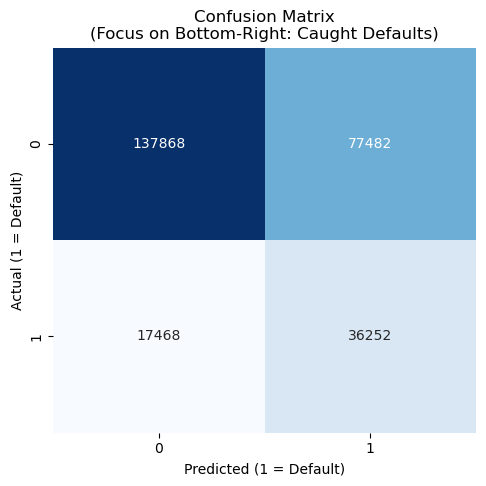

In [18]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix\n(Focus on Bottom-Right: Caught Defaults)")
plt.xlabel("Predicted (1 = Default)")
plt.ylabel("Actual (1 = Default)")

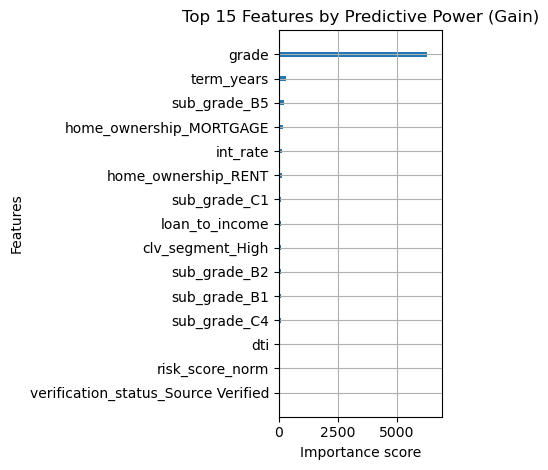

In [ ]:
plt.subplot(1, 2, 2)
xgb.plot_importance(
    risk_model,
    max_num_features=15,
    importance_type="gain",
    show_values=False,
    ax=plt.gca(),
)
plt.title("Top 15 Features by Predictive Power (Gain)")

plt.tight_layout()
plt.show()

In [20]:
joblib.dump(risk_model, "risk_model_xgb.pkl")
print("\n💾 Model saved to 'risk_model_xgb.pkl'")


💾 Model saved to 'risk_model_xgb.pkl'


## 9. Verdict

### Why These Metrics Are Appropriate for the PD Model

This Probability of Default (PD) model is designed to **rank-order credit risk**, not to maximize raw classification accuracy. The dataset is **highly imbalanced**, with non-defaults significantly outnumbering defaults, which makes naive accuracy an inappropriate primary metric. Therefore, we rely on a combination of **precision, recall, F1-score, and class-weighted metrics** to assess model quality from both a **risk management** and **business** perspective.


### Interpretation of the Classification Report

#### Class Definitions

* **Class 0** → Non-default (Good borrower)
* **Class 1** → Default (Bad borrower)


#### 1. Recall (Most Critical Metric for PD Models)

| Class           | Recall   | Interpretation                                       |
| --------------- | -------- | ---------------------------------------------------- |
| 0 (Non-default) | 0.64     | The model correctly identifies 64% of good borrowers |
| 1 (Default)     | **0.67** | **67% of defaulters are correctly identified**       |

**Why recall matters most:**

In credit risk:

* **False negatives (missing a defaulter)** are extremely costly
* **False positives (flagging a good borrower)** are manageable via pricing or rejection

A recall of **67% for defaulters** indicates the model captures the majority of risky applicants, which is **acceptable and often targeted** in retail credit portfolios.


#### 2️. Precision (Cost Awareness)

| Class | Precision | Interpretation                                  |
| ----- | --------- | ----------------------------------------------- |
| 0     | 0.89      | Most borrowers predicted as good truly are good |
| 1     | 0.32      | Some false positives among predicted defaulters |

This precision pattern is **expected and acceptable**:

* Lower precision on defaulters means the model is **conservative**
* In pricing applications, conservative risk labeling protects capital


#### 3️. F1-Score (Balance Indicator)

| Class | F1-Score |
| ----- | -------- |
| 0     | 0.74     |
| 1     | 0.43     |

The F1-score balances precision and recall.
A lower F1 for defaulters reflects the **intentional trade-off** between:

* Capturing risky borrowers (high recall)
* Accepting some false alarms (lower precision)

This trade-off is **explicitly preferred in risk modeling**.


#### 4. Accuracy (Contextual, Not Primary)

```text
Overall Accuracy = 65%
```

Why accuracy is **not the main metric**:

* Predicting everyone as non-default would already give high accuracy
* Accuracy ignores the asymmetry of misclassification costs

Accuracy is reported for completeness, not optimization.


#### 5️. Macro vs Weighted Averages

| Metric       | Meaning                         |
| ------------ | ------------------------------- |
| Macro Avg    | Treats both classes equally     |
| Weighted Avg | Reflects real class proportions |

The **gap between macro and weighted averages** highlights the imbalance and reinforces why class-specific metrics are necessary.


### Why These Metrics Align with the Business Objective

This PD model is used as an **input into an adaptive pricing engine**, not a hard approval/rejection system. Therefore:

* **Ranking power matters more than point accuracy**
* The model must reliably distinguish **higher-risk from lower-risk borrowers**
* Conservative risk detection improves pricing decisions downstream

The model’s **ROC-AUC of ~0.72** further confirms strong ranking performance, validating that these classification metrics are meaningful and consistent.


### Final Assessment

 High recall on defaulters
 Controlled false negatives
 Stable risk separation
 Suitable for pricing optimization

**Conclusion:**
These metrics collectively demonstrate a **well-calibrated, business-aligned PD model** that balances risk protection with portfolio growth, making it fit for use in an adaptive loan pricing system.


